In [ ]:
# Plan:-

# 1.Fine Tune Bert Masked Language Modelling over our address domain data, as using the pretrained embeddings are not sufficient.
# 2.Fine Tune Sentence Transformer (S-Bert) embedding over our data by creating a pair of similar sentences. To fine tune sbert, it expects us
# to create a pair of sentence with the similarity score, so we can create a pair of sentences and use levenshtein distance (fuzzy-wuzzy python
#package) to get similarity score for each pair.
# 3.Then Use Bert Topic and decide which topics corresponds to commercial and residential addresses.
# 4.Then assign crresponding topics tags
# 5.Train Classifier with topics assigned as tags

#So baasically as tags are not provided , my intention is to first perform topic modelling using Bertopic (BERT embeddings, UMAP, HDBSCAN, and
# c-tf-idf). And then use these topics(clustering/Bertopic outputs) as new tags to build a classifier model.
# Out of all topics , we can assign certain topics as commercial and certain as residential

## Things I am not able to do in this notebook, due to time constraint
# Fine Tuning Bert
# Fine SBERT
# Hyperparameter tuning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install umap-learn
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dataset = pd.read_csv('/content/assignment_data_res_com.csv')

In [ ]:
dataset

,id,masked_address,label
0,2,"JAI BALAJI DISTRIBUTORS, NEW MARKET SHOP NO.**...",commercial
1,423,SUNDRAM FASTENERS LIMITED B ** SIPCOT INDUSTRI...,commercial
2,481,"Bakul-*, Shardashish Township, Torrent Power L...",commercial
3,641,"Sonkar Bhawan, Near Ashok Kirana Store, Infron...",commercial
4,4395,"jambli \n maida factory near jambli , jambli,...",commercial
...,...,...,...
10596,10596,"A. Rajeshwari, No.***, Pampatti street, East g...",NaN
10597,10597,"Flat no ***,S.V's srinivasam, nehrunagar , HY...",NaN
10598,10598,"Madhav nagar katni, Near post office road , M...",NaN
10599,10599,"Mig-**, sri sai -* men s pg, Road no-*, kphb c...",NaN


In [ ]:
dataset.iloc[720:730]

,id,masked_address,label
720,718,"Master colony, near jio tower, rajgangpur OCL ...",NaN
721,719,"PLOT NO : ***, SIRUMATHOOR VIL,PADAPPAI SRIPE...",NaN
722,720,"""B-****, Aashirwad Textile Market, Opp. Landma...",NaN
723,721,Flat No ** Pocket ** A Ashoka Appartment Secto...,NaN
724,722,C/O- $$$$ $$$$ JHA GITA SADAN EAST OF KABIR CH...,NaN
725,723,"Bari Khatu,Nagor district , NAGAUR, RAJASTHAN...",NaN
726,724,"defalala bridge \n defalala , patherkandi, As...",NaN
727,725,"No * kalaigaon Mb road , Kalaigaon Town Part...",NaN
728,726,"patel park, ranjitsagar road , plot no. ***/b,...",NaN
729,727,"by paas road,chatra \n by paas road ,nagwan ch...",NaN


In [ ]:
len(dataset)

10601

In [ ]:
 ##Cleaning the texts
 # Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, len(dataset)):
  review = re.sub('[^a-zA-Z]', ' ', dataset['masked_address'][i])
  review = review.lower()
  review=re.sub(' +', ' ', review)
  corpus.append(review)
print(corpus)


['jai balaji distributors new market shop no golden heights building chatribari road kamrup guwahati guwahati assam ', 'sundram fasteners limited b sipcot industrial complex gummidipoondi gummudipoondi tamil nadu ', 'bakul shardashish township torrent power limited off nh kamrej surat gay pagla kim gujarat ', 'sonkar bhawan near ashok kirana store infront of mohan aata chakki lakkhe nagar raipur chhattisgarh ', 'jambli maida factory near jambli jambli maharashtra ', ' prabhat jarda factory road sikandarpur radha devi girls high school muzaffarpur bh ', 'ayodhya drug warehouse kushmaha road near cmo office darshan nagar faizabad uttar pradesh ', 'godown no survey no mu sanathal tal sanand ahmedabad gujarat ', 'herbalife international india pvt ltd c o mill road opp sbi bank aishbag lucknow lucknow uttar pradesh ', 'gopalpur warehousing cmplx basai gopalpur khasra no qila no gurgaon gurgaon haryana ', 'maity para dhaka petrol pump nh dankuni kolkata dankuni west bengal ', 'house padmasha

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
len(corpus)

10601

(array([5.160e+02, 4.424e+03, 4.058e+03, 1.216e+03, 3.050e+02, 6.700e+01,
        1.000e+01, 4.000e+00, 0.000e+00, 1.000e+00]),
 array([  7. ,  36.4,  65.8,  95.2, 124.6, 154. , 183.4, 212.8, 242.2,
        271.6, 301. ]),
 <a list of 10 Patch objects>)

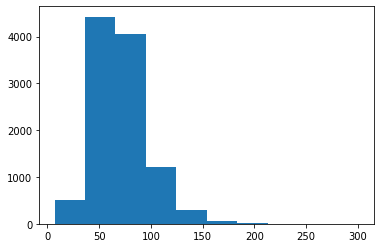

In [ ]:
length_list=[len(i) for i in corpus]
plt.hist(length_list)

In [ ]:
corpus1=[item for item in corpus if len(item)>=20]
print(corpus1)

['jai balaji distributors new market shop no golden heights building chatribari road kamrup guwahati guwahati assam ', 'sundram fasteners limited b sipcot industrial complex gummidipoondi gummudipoondi tamil nadu ', 'bakul shardashish township torrent power limited off nh kamrej surat gay pagla kim gujarat ', 'sonkar bhawan near ashok kirana store infront of mohan aata chakki lakkhe nagar raipur chhattisgarh ', 'jambli maida factory near jambli jambli maharashtra ', ' prabhat jarda factory road sikandarpur radha devi girls high school muzaffarpur bh ', 'ayodhya drug warehouse kushmaha road near cmo office darshan nagar faizabad uttar pradesh ', 'godown no survey no mu sanathal tal sanand ahmedabad gujarat ', 'herbalife international india pvt ltd c o mill road opp sbi bank aishbag lucknow lucknow uttar pradesh ', 'gopalpur warehousing cmplx basai gopalpur khasra no qila no gurgaon gurgaon haryana ', 'maity para dhaka petrol pump nh dankuni kolkata dankuni west bengal ', 'house padmasha

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=3, n_components=20, min_dist=0.05)
hdbscan_model = HDBSCAN(min_cluster_size=100,
                        prediction_data=True, gen_min_span_tree=True)

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english'))

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
#model.fit(data['selftext'])
topics, probs = model.fit_transform(corpus1)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/331 [00:00<?, ?it/s]

2023-01-11 10:00:46,145 - BERTopic - Transformed documents to Embeddings
2023-01-11 10:01:13,321 - BERTopic - Reduced dimensionality
2023-01-11 10:01:17,276 - BERTopic - Clustered reduced embeddings


In [ ]:
for i in range(5):
    print(f"{topics[i]}: {corpus1[i]}")

13: jai balaji distributors new market shop no golden heights building chatribari road kamrup guwahati guwahati assam 
13: sundram fasteners limited b sipcot industrial complex gummidipoondi gummudipoondi tamil nadu 
0: bakul shardashish township torrent power limited off nh kamrej surat gay pagla kim gujarat 
-1: sonkar bhawan near ashok kirana store infront of mohan aata chakki lakkhe nagar raipur chhattisgarh 
12: jambli maida factory near jambli jambli maharashtra 


In [ ]:
freq = model.get_topic_info()
freq

,Topic,Count,Name
0,-1,3505,-1_near_road_maharashtra_nagar
1,0,945,0_bangalore_karnataka_flat_th
2,1,550,1_nadu_tamil_tamil nadu_street
3,2,388,2_telangana_hyderabad_hyderabad telangana_colony
4,3,380,3_school_near_high_high school
5,4,346,4_andhra pradesh_andhra_pradesh_karnataka
6,5,306,5_kerala_kollam_po_kollam kerala
7,6,287,6_bihar_ward_bihar ward_patna
8,7,274,7_house_nagar_road_near
9,8,272,8_plot_sector_gurgaon_haryana


In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_hierarchy()

In [ ]:
model.visualize_barchart()

In [ ]:
#Topic 3,13 and 17 corresponds to commercial address based on top 5 words in the cluster, total samples in these clusters are 818

In [ ]:
##Topics are getting focussed over states, so we will consider only first half of the address which I beleive will have relevant information
# to decide whether an address is commercial or residential
corpus2=[" ".join(temp.split(" ")[:len(temp.split(" "))//2]) for temp in corpus1]
print(corpus2)

['jai balaji distributors new market shop no golden', 'sundram fasteners limited b sipcot industrial', 'bakul shardashish township torrent power limited off', 'sonkar bhawan near ashok kirana store infront of', 'jambli maida factory near', ' prabhat jarda factory road sikandarpur radha', 'ayodhya drug warehouse kushmaha road near cmo', 'godown no survey no mu', 'herbalife international india pvt ltd c o mill road', 'gopalpur warehousing cmplx basai gopalpur khasra', 'maity para dhaka petrol pump nh', 'house padmashali steet', 's o rly stnchirala pomdl prakasam dt andhra', ' ramnager bagha ramnager', ' behind ishvar', 'roha roth khurd jm rathi english', ' v mathu mathi melur', ' amarjothi pon nagar st maniyakarapalayam road', ' s knagar velagoundanur kattuvalavu kottai mariyamman panjayat pachanampatti ganapathy super', 'shriman pur shriman pur', ' kummari bazar vemulaplly near by', 'katr primary school karta', 'plot no g survey no hissa no part cts no', 'block no plot no priadarshini',

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=3, n_components=20, min_dist=0.05)
hdbscan_model = HDBSCAN(min_cluster_size=100,
                        prediction_data=True, gen_min_span_tree=True)

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english')) #+ ['http', 'https', 'amp', 'com']

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
#model.fit(data['selftext'])
topics, probs = model.fit_transform(corpus2)

Batches:   0%|          | 0/331 [00:00<?, ?it/s]

2023-01-11 10:02:09,282 - BERTopic - Transformed documents to Embeddings
2023-01-11 10:02:18,775 - BERTopic - Reduced dimensionality
2023-01-11 10:02:22,185 - BERTopic - Clustered reduced embeddings


In [ ]:
for i in range(5):
    print(f"{topics[i]}: {corpus2[i]}")

4: jai balaji distributors new market shop no golden
-1: sundram fasteners limited b sipcot industrial
4: bakul shardashish township torrent power limited off
-1: sonkar bhawan near ashok kirana store infront of
-1: jambli maida factory near


In [ ]:
freq = model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,4475,-1_near_road_nagar_street
1,0,2049,0_vill_po_bazar_post
2,1,776,1_road_street_road near_near
3,2,424,2_flat_apartment_floor_apartments
4,3,402,3_colony_colony near_near_nagar
5,4,399,4_plot_pvt_ltd_pvt ltd
6,5,396,5_house_po_nagar_village
7,6,327,6_nagar_near_nagar near_mall
8,7,289,7_floor_st_th_st floor
9,8,269,8_school_college_primary_primary school


In [ ]:
freq

,Topic,Count,Name
0,-1,4475,-1_near_road_nagar_street
1,0,2049,0_vill_po_bazar_post
2,1,776,1_road_street_road near_near
3,2,424,2_flat_apartment_floor_apartments
4,3,402,3_colony_colony near_near_nagar
5,4,399,4_plot_pvt_ltd_pvt ltd
6,5,396,5_house_po_nagar_village
7,6,327,6_nagar_near_nagar near_mall
8,7,289,7_floor_st_th_st floor
9,8,269,8_school_college_primary_primary school


In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_hierarchy()

In [ ]:
model.visualize_barchart()

In [ ]:
# 4,8 and 11 corresponds to commercial address, total samples in these clusters are 821.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=50, n_components=20, min_dist=0.1)
hdbscan_model = HDBSCAN(min_cluster_size=100,
                        prediction_data=True, gen_min_span_tree=True)

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stopwords = list(stopwords.words('english'))

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stopwords)

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
#model.fit(data['selftext'])
topics, probs = model.fit_transform(corpus2)

Batches:   0%|          | 0/331 [00:00<?, ?it/s]

2023-01-11 10:19:15,866 - BERTopic - Transformed documents to Embeddings
2023-01-11 10:19:47,095 - BERTopic - Reduced dimensionality
2023-01-11 10:19:50,239 - BERTopic - Clustered reduced embeddings


In [ ]:
for i in range(5):
    print(f"{topics[i]}: {corpus2[i]}")

9: jai balaji distributors new market shop no golden
-1: sundram fasteners limited b sipcot industrial
-1: bakul shardashish township torrent power limited off
9: sonkar bhawan near ashok kirana store infront of
-1: jambli maida factory near


In [ ]:
freq = model.get_topic_info()
freq

,Topic,Count,Name
0,-1,4930,-1_near_road_street_post
1,0,1917,0_vill_po_post_bazar
2,1,691,1_road_street_main road_main
3,2,560,2_floor_flat_apartment_sector
4,3,501,3_nagar_nagar near_near_street
5,4,381,4_colony_colony near_near_vihar colony
6,5,329,5_house_house village_po_home
7,6,250,6_school_college_primary_primary school
8,7,246,7_near_near near_club_temple
9,8,199,8_plot_plot plot_ltd plot_nagar


In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_hierarchy()

In [ ]:

model.visualize_barchart()

In [ ]:
##here we can observe that topics 6,8,9 and 12 are the indication of commercial addresses.

In [ ]:
#Because of poor embeddings (without fine-tuning) out of total 10590 addresses, many of them are not assigned to any topics, they are outliers
topics=np.array(topics)
corpus2=np.array(corpus2)
Outliers=np.where(topics==-1)[0]
print("Outliers are: ",len(Outliers))

Outliers are:  4930


In [ ]:
topics1=topics[np.where(topics>-1)]
corpus3=corpus2[np.where(topics>-1)]

In [ ]:
from collections import Counter
Counter(topics1)

Counter({9: 186,
         0: 1917,
         7: 246,
         6: 250,
         8: 199,
         1: 691,
         5: 329,
         11: 148,
         2: 560,
         4: 381,
         3: 501,
         10: 150,
         12: 102})

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

In [ ]:
data=pd.DataFrame({"text":corpus3,"gt":topics1})
data

,text,gt
0,jai balaji distributors new market shop no golden,9
1,sonkar bhawan near ashok kirana store infront of,9
2,herbalife international india pvt ltd c o mill...,9
3,s o rly stnchirala pomdl prakasam dt andhra,0
4,roha roth khurd jm rathi english,0
...,...,...
5655,sharma ultrasound kali mai,0
5656,b alcon renaissant tulja bhawani,0
5657,hasanpur bithan hasanpur,0
5658,add rathiala sushil nadone nr iswar,0


In [ ]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

In [ ]:
max_len=64
sentences=data['text']
labels=data['gt']
len(sentences),len(labels)

(5660, 5660)

In [ ]:
dbert_tokenizer.tokenize(sentences[0])

['jai',
 'bala',
 '##ji',
 'distributors',
 'new',
 'market',
 'shop',
 'no',
 'golden']

In [ ]:
dbert_inp=dbert_tokenizer.encode_plus(sentences[0],add_special_tokens = True,max_length =64,pad_to_max_length = True,truncation=True)
dbert_inp

{'input_ids': [101, 17410, 21451, 4478, 22495, 2047, 3006, 4497, 2053, 3585, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
id_inp=np.asarray(dbert_inp['input_ids'])
mask_inp=np.asarray(dbert_inp['attention_mask'])
out=dbert_model([id_inp.reshape(1,-1),mask_inp.reshape(1,-1)])
type(out),out

(transformers.modeling_tf_outputs.TFBaseModelOutput,
 TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 64, 768), dtype=float32, numpy=
 array([[[-0.02830041, -0.21547984, -0.07247663, ..., -0.16309763,
           0.36624083,  0.15755449],
         [ 0.46900827,  0.06829842,  0.17230383, ..., -0.12179179,
           0.24171756, -0.4118856 ],
         [ 0.54940027, -0.25860292, -0.1414032 , ..., -0.20239742,
           0.04366536, -0.01591296],
         ...,
         [ 0.4036928 , -0.04673804,  0.17725748, ..., -0.06507759,
          -0.00497   , -0.2671354 ],
         [ 0.3111696 , -0.09088967,  0.13189173, ...,  0.01525415,
          -0.07319129, -0.01811665],
         [ 0.09107904, -0.14819196, -0.04420243, ...,  0.07526976,
           0.01441815,  0.07411964]]], dtype=float32)>, hidden_states=None, attentions=None))

In [ ]:
dbert_tokenizer.decode(dbert_inp['input_ids'])


'[CLS] jai balaji distributors new market shop no golden [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(len(np.unique(topics1)), activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [ ]:
model=create_model()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_3[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_4[0][0]']                
                                one, 64, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [ ]:
label_class_dict={6:'commercial1',8:'commercial2',9:'commercial3',12:'commercial4',
                  0:'residential1',1:'residential2',2:'residential3',3:'residential4',
                  4:'residential5',5:'residential6',7:'residential7',10:'residential8',11:'residential9'}
target_names=label_class_dict.values()
target_names

dict_values(['commercial1', 'commercial2', 'commercial3', 'commercial4', 'residential1', 'residential2', 'residential3', 'residential4', 'residential5', 'residential6', 'residential7', 'residential8', 'residential9'])

In [ ]:
len(target_names)

13

In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

log_dir='dbert_model'
model_save_path='./dbert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (4528, 64) Val input shape (1132, 64)
Train label shape (4528,) Val label shape (1132,)
Train attention mask shape (4528, 64) Val attention mask shape (1132, 64)


In [ ]:
callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [ ]:
history=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=5,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)


Epoch 1/5
283/283 [==============================] - 44s 129ms/step - loss: 6.6036 - accuracy: 0.8511 - val_loss: 5.9165 - val_accuracy: 0.9567
Epoch 2/5
283/283 [==============================] - 38s 133ms/step - loss: 5.5207 - accuracy: 0.9704 - val_loss: 5.2091 - val_accuracy: 0.9629
Epoch 3/5
283/283 [==============================] - 38s 136ms/step - loss: 4.8076 - accuracy: 0.9814 - val_loss: 4.5914 - val_accuracy: 0.9541
Epoch 4/5
283/283 [==============================] - 40s 141ms/step - loss: 4.1369 - accuracy: 0.9859 - val_loss: 3.9591 - val_accuracy: 0.9576
Epoch 5/5
283/283 [==============================] - 38s 133ms/step - loss: 3.5237 - accuracy: 0.9905 - val_loss: 3.3620 - val_accuracy: 0.9594


In [ ]:
preds = model.predict([val_inp,val_mask],batch_size=16)
pred_labels = preds.argmax(axis=1)
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=target_names))


71/71 [==============================] - 5s 44ms/step
Classification Report
              precision    recall  f1-score   support

 commercial1       0.98      0.99      0.98       409
 commercial2       0.96      0.95      0.96       144
 commercial3       0.93      0.98      0.96       119
 commercial4       1.00      0.91      0.95        88
residential1       0.98      0.97      0.98        67
residential2       0.97      0.97      0.97        73
residential3       0.95      0.93      0.94        44
residential4       0.96      0.88      0.91        49
residential5       1.00      0.97      0.98        31
residential6       0.86      0.89      0.87        35
residential7       0.83      1.00      0.91        25
residential8       0.89      0.93      0.91        27
residential9       0.90      0.86      0.88        21

    accuracy                           0.96      1132
   macro avg       0.94      0.94      0.94      1132
weighted avg       0.96      0.96      0.96      1132

